In [1]:
import torch, os
import sys, cv2
import matplotlib.pyplot as plt

sys.path.append('/home/shshin/Scalable-Hyperspectral-3D-Imaging')
from hyper_sl.utils import _constants as C

device = 'cuda'

/home/shshin/.conda/envs/hyper3d/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### grid pattern 생성

In [2]:
from PIL import Image, ImageDraw

# Define the size of the image
width = 1280
height = 720

# Define the size of each dot
dot_size = 3
margin = 200

# Create a new image with a white background
img = Image.new('RGB', (width, height), color='black')

# Get a drawing context for the image
draw = ImageDraw.Draw(img)

# Draw dots on the image in a grid pattern
for x in range(0, width, dot_size + margin):
    for y in range(0, height, dot_size + margin):
        draw.ellipse((x, y, x+dot_size, y+dot_size), fill='white')
        
# Save the image
img.save('grid_dot_pattern.png')

#### Input pixel location where white dots exist

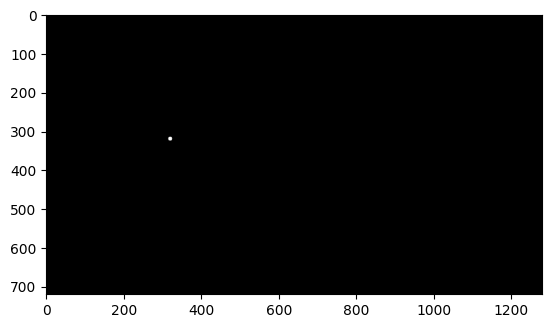

In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# set illum dimensions and dot spacing
illum_height = 720
illum_width = 1280
dot_size = 5

# create tensor representing black illum
illum = torch.zeros((illum_height, illum_width))


# get user input for circle center locations
centers = []
while True:
    center_input = input("Enter the x,y coordinates of a circle center (or 'done' to finish): ")
    if center_input == 'done':
        break
    else:
        x, y = center_input.split(',')
        centers.append((int(x), int(y)))

# loop through the illum and set pixels within the circles to white
for i in range(illum_height):
    for j in range(illum_width):
        for center in centers:
            if (i - center[0])**2 + (j - center[1])**2 <= dot_size**2:
                illum[i, j] = 1

# resize the illum to a square and convert to a PyTorch variable
illum = illum.unsqueeze(0).unsqueeze(0)
illum = F.interpolate(illum, size=(illum_height, illum_width))
illum = illum.squeeze()
illum_np = illum.squeeze().numpy()

# plot the illum using matplotlib
plt.imshow(1-illum, cmap='binary')
cv2.imwrite('dot.png',illum_np*255.)
# plt.imshow(illum), plt.colorbar()
plt.show()

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# set illum dimensions and dot spacing
illum_height = 720
illum_width = 1280

# create tensor representing black illum
illum = torch.zeros((illum_height, illum_width))


# get user input for circle center locations
illum[int(illum_height/2)-1:int(illum_height/2)+1,int(illum_width/2)-1:int(illum_width/2)+1]=1
illum_np = illum.numpy()
cv2.imwrite('dot.png',illum_np*255.)

True

### Camera captured Image 가져오기

In [5]:
def bring_cap_img():
    img_path = ''
    img_fn = ''
    captured_img = cv2.imread(os.path.join(img_path, img_fn), -1)
    captured_img = torch.tensor(captured_img)
    
    return captured_img

(1536, 2048)

In [ ]:
def find_idx_real():
    capt_img = bring_cap_img()
    idx = torch.where(capt_img == 1)
    
    return idx

## Depth 알아내기

In [6]:
# Intrinsic of projector

proj_sensor_diag = C.PROJ_DIAG *1e-3
proj_focal_length = C.PROJ_FOCAL_LENGTH *1e-3
proj_H = 720
proj_W = 1280
sensor_width_proj = torch.sin(torch.atan2(torch.tensor(proj_H),torch.tensor(proj_H)))*proj_sensor_diag
proj_pitch = sensor_width_proj/proj_H

In [7]:
# Intrinsic of camera

cam_H, cam_W = 1536, 2048
sensor_width_cam = 5.32 * 1e-3
cam_pitch = sensor_width_cam / cam_H
focal_length_cam = 8 * 1e-3

##### Unprojection

In [8]:
def unprojection(depth):
        """ Unproject camera sensor coord plane to world coord

            input : depth
            return : world coordinate X,Y,Z
            
        """
        c, r = torch.meshgrid(torch.linspace(0,cam_H-1,cam_H), torch.linspace(0,cam_W-1,cam_W), indexing='ij') # 행렬 indexing
        
        x_c, y_c = (r-cam_W/2)*cam_pitch, (c-cam_H/2)*cam_pitch
        x_c, y_c = x_c.reshape(cam_W*cam_H), y_c.reshape(cam_W*cam_H)
        # z_c = torch.zeros_like(x_c)
        # z_c[:] = -focal_length_cam
        
        X,Y,Z = -x_c/focal_length_cam*depth, -y_c/focal_length_cam*depth, -depth
        
        return X,Y,Z

##### extrinsic matrix of projector

In [9]:
def extrinsic_proj_real():
        """ World coordinate to real proj's coordinate
        
        """
        extrinsic_proj_real = torch.zeros((4,4)).to(device)
        # no rotation
        extrinsic_proj_real[0,0] = 1 
        extrinsic_proj_real[1,1] = 1
        extrinsic_proj_real[2,2] = 1

        # translate + x 50e-3
        extrinsic_proj_real[0,3] = 50e-3 
        extrinsic_proj_real[3,3] = 1
        
        return extrinsic_proj_real

##### Projection

In [10]:
def projection(X,Y,Z):
        """
            input : object's XYZ coordinate
                    extrinsic matrix of rproj to vproj (vproj)
                    focal length of virtual projector
                    
            outputs : virtual projector sensor coordinate (in virtual proj's coordinate)
        """

        # focal_length_proj_virtual : 3, 77

        X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
        XYZ1 = torch.stack((X,Y,Z,torch.ones_like(X)), dim = 0).to(device=device)

        # XYZ coords in virtual proj's coordinate                   
        XYZ_vir = torch.linalg.inv(extrinsic_proj_real())@XYZ1
        XYZ_vir = XYZ_vir[:3,:] 
        
        print(XYZ_vir.shape)
        XYZ_vir_z = torch.unsqueeze(XYZ_vir[2,:] , dim = 0)

        xy_proj = (-proj_focal_length*XYZ_vir[:2,:]/XYZ_vir_z)

        return xy_proj 

##### find the idx of white camera pixel

In [11]:
def find_idx(xy_proj, illum):
    
    r_proj = xy_proj[0,:]/proj_pitch + proj_W/2
    c_proj = xy_proj[1,:]/proj_pitch + proj_H/2

    rc_proj = torch.cat((r_proj.unsqueeze(dim = 1), c_proj.unsqueeze(dim =1)), dim = 1)

    r_proj, c_proj = rc_proj[...,1], rc_proj[...,0]
    
    cond = (0<= r_proj)*(r_proj < proj_H)*(0<=c_proj)*(c_proj< proj_W)
    r_proj_valid, c_proj_valid = r_proj[cond], c_proj[cond]
    r_proj_valid, c_proj_valid = torch.tensor(r_proj_valid), torch.tensor(c_proj_valid)  # TODO: do we need this?

    new_idx = proj_W * r_proj_valid.long() + c_proj_valid.long()      
    
    illum_img = torch.zeros(size=(640,640))

    illum = illum.reshape(proj_H*proj_W).to(device=device)
    valid_pattern_img=illum[new_idx]

    illum_img = torch.zeros(size=(cam_H*cam_W,), device = device)
    illum_img[cond.flatten()] = valid_pattern_img
    
    illum_img = illum_img.reshape(cam_H, cam_W)
    
    check = torch.where(illum_img == 1)
    
    return check, illum_img

### Depth value to be optimized

In [12]:
# optimize depth value

epoch = 1000
loss_f = torch.nn.L1Loss()

lr = 1e-3
decay_step = 500

losses = []

depth_value = torch.randn(1, requires_grad = True, device = device)
print('initialized depth value : ', depth_value)

optimizer = torch.optim.Adam([depth_value], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = 0.5)

for i in range(epoch):
    # depth value
    depth = torch.zeros(size=(cam_H* cam_W,))
    depth[:] = depth_value

    # Unproject to 3D points
    X,Y,Z = unprojection(depth=depth)

    # Projector to projector
    xy_proj = projection(X,Y,Z)

    # find camera index
    cam_idx, illum_img = find_idx(xy_proj, illum)

    # index of real captured img
    real_idx = find_idx_real()

    loss = loss_f(cam_idx,real_idx)
    
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    if i % 100 == 0:
            print(f" Epoch : {epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

initialized depth value :  tensor([-1.4431], device='cuda:0', requires_grad=True)


## Diffraction grating calibration

#### camera pixel position from catured image

In [17]:
# 특정 파장의 빛이 있는 camera pixel 위치 알아내기?

#### camera pixel position from unproj & proj method

#### Optimization